In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
from PIL import ImageDraw
import pandas as pd
import numpy as np
import xml.etree.ElementTree as ET
from sklearn.model_selection import train_test_split
import torch
from torch import cuda
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import tqdm
import random
import os

random.seed(1337)

device = 'cuda' if cuda.is_available() else 'cpu'

In [ ]:
### Download Dataset (~15gb)

import kagglehub

path = kagglehub.dataset_download("ronanpickell/b100-lego-detection-dataset")

print("Path to dataset files:", path)

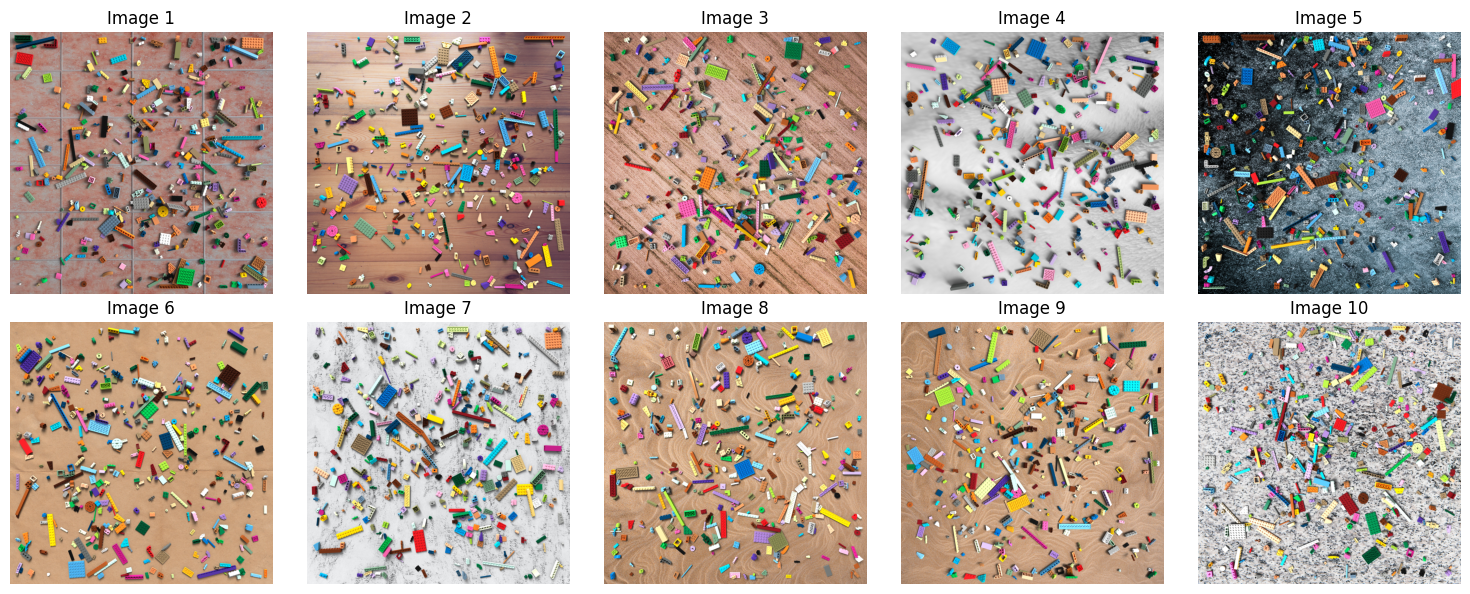

In [16]:
### Visualizing the Data

# Return all image paths
def process_images(directory):
    image_paths = []
    for root, dirs, files in os.walk(directory):
        for filename in files:
            if filename.lower().endswith('.png'):
                image_path = os.path.join(root, filename)
                image_paths.append(image_path)
    return image_paths

# Plot 10 random images from image_paths
def plot_random_images(directory):
    image_paths = process_images(directory)
    
    if len(image_paths) == 0:
        print("No images found in the directory.")
        return
    
    num_images = 10
    random_images = random.sample(image_paths, num_images)
    
    rows = 2
    fig, axes = plt.subplots(rows, 5, figsize = (15, 3 * rows))
    axes = axes.flatten()

    for i, image_path in enumerate(random_images):
        img = Image.open(image_path)
        
        axes[i].imshow(img)
        axes[i].set_title(f"Image {i + 1}")
        axes[i].axis('off')
    
    # Turn off any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

plot_random_images('images')

In [ ]:
### Preprocessing Data

# Read in data
def pair_images_annotations(image_dir, anno_dir):
    images = [f for f in os.listdir(image_dir) if f.lower().endswith('.png')]
    annos = [f for f in os.listdir(anno_dir) if f.lower().endswith('.xml')]
    pairs = []
    for img in images:
        base = os.path.splitext(img)[0]
        anno_file = base + '.xml'
        if anno_file in annos:
            pairs.append((os.path.join(image_dir, img), os.path.join(anno_dir, anno_file)))
    return pairs

pairs = pair_images_annotations('images', 'annotations')

# Parse XML annotations (BBs and Labels)
def parse_voc_xml(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    boxes = []
    names = []
    colors = []

    for obj in root.findall('object'):
        name = obj.find('name').text
        bbox = obj.find('bndbox')
        box = [
            int(bbox.find('xmin').text),
            int(bbox.find('ymin').text),
            int(bbox.find('xmax').text),
            int(bbox.find('ymax').text)
        ]

        color = obj.find('color').text if obj.find('color') is not None else None

        # Strip leading 'm'
        if color is not None and color.startswith('m'):
            color = color[1:]

        # Replace trailing 'b' or 'c' with '9'
        if name is not None and name.endswith(('b', 'c')):
            name = name[:-1] + '9'

        boxes.append(box)
        names.append(name)
        colors.append(color)

    # Convert lists to numpy arrays and then astype int
    boxes = np.array(boxes).astype(int)
    names = np.array(names).astype(int)
    colors = np.array(colors).astype(int)

    return boxes, names, colors

# Aggregate all data
all_data = []

for img_path, anno_path in pairs:
    boxes, names, colors = parse_voc_xml(anno_path)
    image_id = os.path.basename(img_path)
    for box, name, color in zip(boxes, names, colors):
        all_data.append({
            'image_id': image_id,
            'box': box,
            'name': name,
            'color': color
        })

full_data = pd.DataFrame(all_data)

# Remove invalid boxes (i.e., [0, 0, 0, 0] or negative coords)
def is_valid_box(box):
    xmin, ymin, xmax, ymax = box
    return (xmax > xmin) and (ymax > ymin)

full_data = full_data[full_data['box'].apply(is_valid_box)].reset_index(drop = True)

# Label classes appropriately
unique_labels = sorted(full_data['name'].unique())
label_to_idx = {label: idx + 1 for idx, label in enumerate(unique_labels)}  # start at 1; 0 reserved for background

## Split the dataset into train and validation sets
# Doing it this way to ensure that each image_id is only in one set
unique_image_ids = full_data['image_id'].unique()

train_ids, val_ids = train_test_split(
    unique_image_ids, test_size = 0.2, random_state = 1337, shuffle = True
)

train_df = full_data[full_data['image_id'].isin(train_ids)].reset_index(drop = True) # Reset index important
val_df = full_data[full_data['image_id'].isin(val_ids)].reset_index(drop = True)

print("Train shape:", train_df.shape)
print("Validation shape:", val_df.shape)

# Create custom dataloader for PyTorch
class LegoDetectionDataset(Dataset):
    def __init__(self, dataframe, img_dir, transform = None):
        self.dataframe = dataframe
        self.img_dir = img_dir
        self.transform = transform
        self.image_ids = dataframe['image_id'].unique()

    def __len__(self):
        return len(self.image_ids) 

    def __getitem__(self, idx):
        image_id = self.image_ids[idx]
        records = self.dataframe[self.dataframe['image_id'] == image_id]
        img_path = os.path.join(self.img_dir, image_id)
        image = read_image(img_path).float() / 255.0  # Normalize to [0,1]

        boxes_np = np.stack(records['box'].values)
        boxes = torch.from_numpy(boxes_np).float()

        labels_raw = records['name'].tolist()
        labels_mapped = [label_to_idx[lbl] for lbl in labels_raw]
        labels = torch.tensor(labels_mapped, dtype=torch.int64)

        colors = torch.tensor(records['color'].tolist(), dtype = torch.int64)

        targets = {
            'boxes': boxes,
            'labels': labels,
            'colors': colors
        }

        if self.transform:
            image = self.transform(image)
        return image, targets
    
train_dataset = LegoDetectionDataset(train_df, 'images')
val_dataset = LegoDetectionDataset(val_df, 'images')

# Create Dataloader Object to Send to Model
# Smaller batch size == less VRAM needed (8 works with 16gb VRAM)
batch_size = 8 # Could have different sizes for train/val, val can be larger for improved efficiency

params = {'batch_size': batch_size,
                'shuffle': True,
                'num_workers': 0
                }

def collate_fn(batch):
    images, targets = list(zip(*batch))
    return list(images), list(targets)

train_loader = DataLoader(train_dataset, **params, collate_fn = collate_fn)
val_loader = DataLoader(val_dataset, **params, collate_fn = collate_fn)

Train shape: (639986, 4)
Validation shape: (159998, 4)


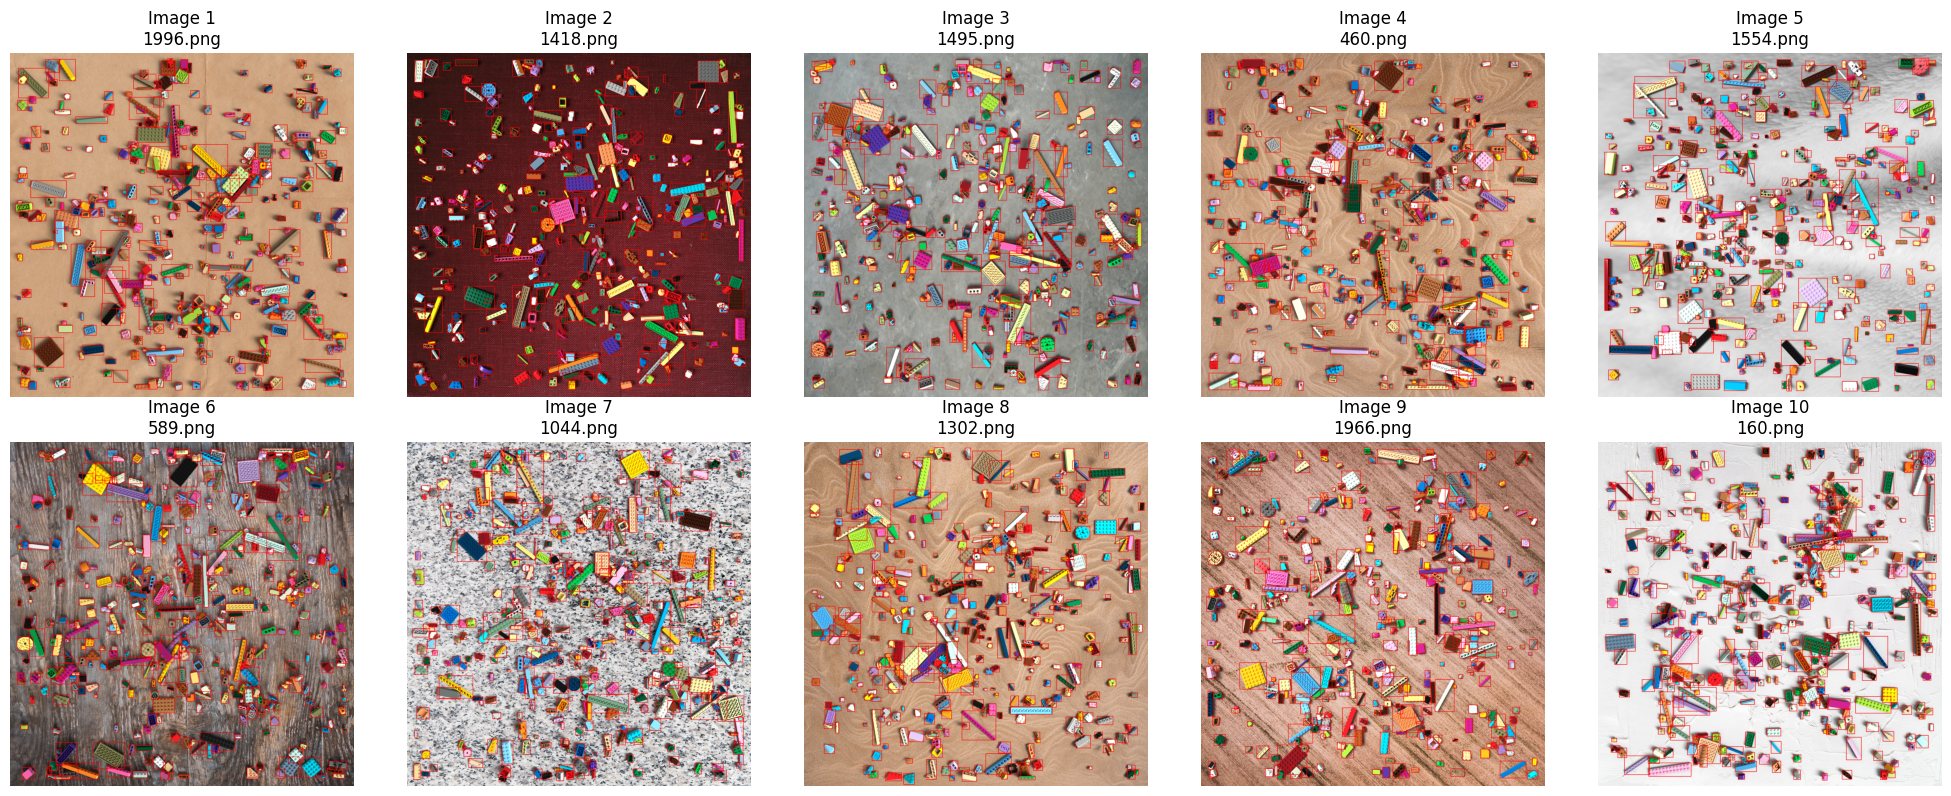

In [28]:
### Showing Images with Bounding Boxes

# Plot images with the given bounding boxes
def plot_images_with_detection(full_data):
    images_with_detections = []
    selected_images = full_data.sample(10)
    selected_images = selected_images['image_id']
    selected_images = [os.path.join('images/', img) for img in selected_images]  # Ensure paths are correct

    for image_path in selected_images:
        image_id = os.path.basename(image_path)
        boxes = full_data[full_data['image_id'] == image_id]['box'].tolist() # Get all bounding boxes for this image
        image = Image.open(image_path).convert("RGB")
        draw = ImageDraw.Draw(image)

        for box in boxes:
            draw.rectangle(box, outline = 'red', width = 3)
        images_with_detections.append((image, image_path))
    
    # Plot the images
    rows = 2
    fig, axes = plt.subplots(rows, 5, figsize = (20, 4 * rows))
    axes = axes.flatten()

    for i, (image, image_path) in enumerate(images_with_detections):
        axes[i].imshow(image)
        axes[i].set_title(f"Image {i + 1}\n{os.path.basename(image_path)}")
        axes[i].axis('off')
    
    # Turn off any unused subplots
    for j in range(len(images_with_detections), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

# Call
plot_images_with_detection(full_data)

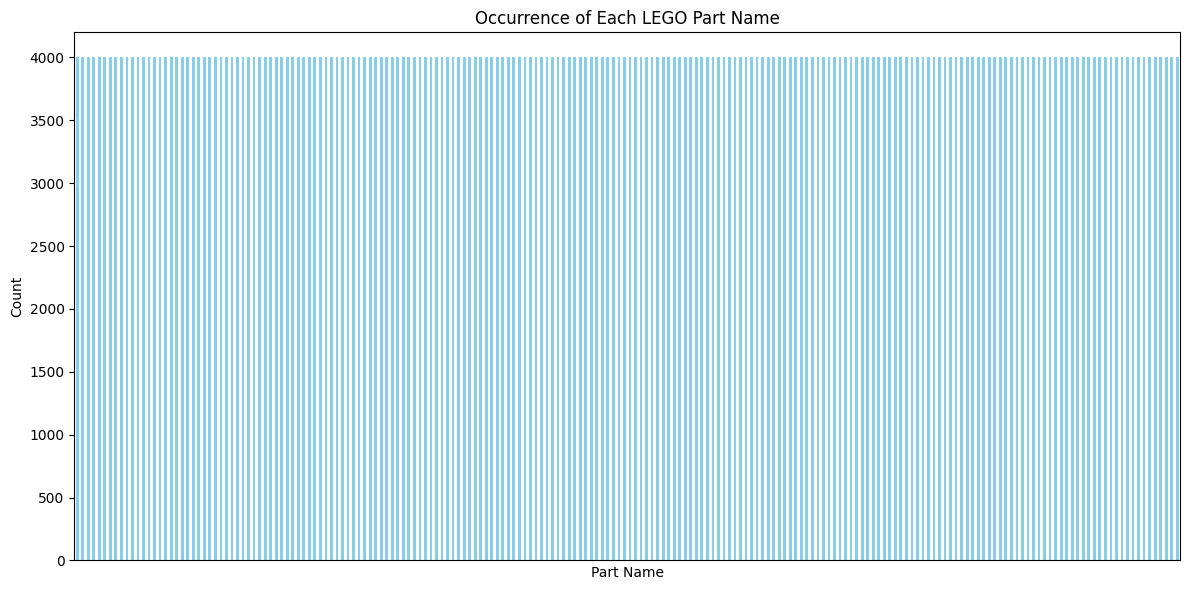

In [7]:
### Visualize Dataset Statistics

## This is done to inform model selection and training (if the data isn't already perfect...)
# It's synthetic, so all classes are balanced
# There are 800,000 Lego pieces on 2000 different images
# There are 200 different parts and 40 different colors

# Count occurrences of each 'name'
name_counts = full_data['name'].value_counts()

# Plot barplot
plt.figure(figsize = (12, 6))
name_counts.plot(kind='bar', color='skyblue')
plt.title('Occurrence of Each LEGO Part Name')
plt.xlabel('Part Name')
plt.ylabel('Count')
plt.xticks([], [])
plt.tight_layout()
plt.show()

In [ ]:
### Finetune an Object Detection Model (Faster R-CNN ResNet)

## Not using instance segmentation (i.e., Mask R-CNN) because my dataset does not have masks
## Could add a parameter serach for optimizer and lr_scheduler, but I don't have an A100...

def get_model_segmentation(full_data):

    # Load pre-trained Faster R-CNN model
    model = fasterrcnn_resnet50_fpn(weights = 'DEFAULT')

    # Get the number of input features and classes
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    num_classes = full_data['name'].nunique() + 1

    # Replace the box predictor head
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

model = get_model_segmentation(full_data)

# Move model to (preferably) GPU
model.to(device)
print(f"Model is on device: {next(model.parameters()).device}")

# Define optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(
    params,
    lr = 0.001,
    weight_decay = 0.0005
)

# Define learning rate scheduler 
lr_scheduler = torch.optim.lr_scheduler.StepLR( 
    optimizer,
    step_size = 3,
    gamma = 0.1
)

# Define loss function
def loss_fn(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

# Train
num_epochs = 5

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    
    # Training
    for images, targets in tqdm.tqdm(train_loader, desc = f"Epoch {epoch + 1}"):
        images = [img.to(device) for img in images]
        targets = [
            {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()}
            for t in targets
        ]

        optimizer.zero_grad()
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        losses.backward()
        optimizer.step()

        epoch_loss += losses.item()

    lr_scheduler.step()

    avg_train_loss = epoch_loss / len(train_loader)
    
    model.eval()
    val_loss = 0.0

    # Validation
    with torch.no_grad():
        for images, targets in val_loader:
            images = [img.to(device) for img in images]
            targets = [
                {k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()}
                for t in targets
            ]

            optimizer.zero_grad()
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_loss += losses.item()

    avg_val_loss = val_loss / len(val_loader)

    print(
        f"Epoch {epoch + 1} | train_loss: {avg_train_loss:.4f} | val_loss: {avg_val_loss:.4f}"
    )


In [ ]:
## Using instance segmentation model (Faster R-CNN with Mask R-CNN head)
# R-CNN is for object detection tasks, and Mask R-CNN extends it to instance segmentation
# R-CNN works by extracting features, using a regional proposal network (RPN) to propose bounding boxes, and a pooling layer to extract features from those boxes
# Add a mask head to then perform instance segmentation and produce predicted masks for each object (this allows for classification)

## There are three forms of segmentation 
# Semantic Segmentation adds in basic labeling, however, this form of segmentation cannot differentiate between two objects of the same class
# Instance segmentation is able to differentiate between objects of the same class
# Panoptic segmentation combines both to produce a label and differentiate between separate instances of the same category

## Other Instance Segmentation Algorithms (outside of Mask R-CNN)
# CenterMask, BlendMask, YOLACT, SOLO, and HTC

In [ ]:
### Finetune an Object Detection Model with an Panoptic Segmentation Model (Panoptic ResNet)

In [ ]:
### Creating a Custom Model